# First pass analysis of line/loop data

<ul>
    <li> Analyse correct sequence lengths. </li>
    <li> Do reaction times </li>
    <li> Analyse as a function of distance from reward </li>
    <li> Try to fit RL model to these data </li> 
    
</ul>

In [140]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn
import scipy.stats as stt
seaborn.set(font_scale=1.5,style='ticks',rc={'axes.edgecolor': 'k',
                                             'axes.linewidth': 2,
                                             #'xtick.major.size': 6,
                                             'axes.labelcolor':'k',
                                             'xtick.major.width': 2,
                                             'ytick.major.width': 2,
                                             'xtick.major.pad': 5.5,
                                             'ytick.major.pad': 5.5,
                                             'axes.labelsize': 18
                                            })
import os
import re
import sys
import itertools
import networkx as nx
sys.path.append("/Users/Yves/Documents/Code/structural_knowledge/packages/")

In [2]:
import mouse_poker as mpk

# Defined functions 

In [3]:
poke_pos = [ [149,0],
         [68,19],[231,19],
       [0,62],[149,62],[298,62],
         [68,105],[231,105],
              [149,124]]

In [4]:
def get_poke_to_state_map(lines):
    """ """
    tmp = []
    for i,j in zip([int(re.findall('POKEDPORT_([0-9])',i)[0]) for i in lines if '_POKEDPORT' in i],
                         [int(re.findall('POKEDSTATE_([0-9])',i)[0]) for i in lines if '_POKEDSTATE' in i]):

        if [i,j] not in tmp:
            tmp.append([i,j])
    poke_to_state_map = [i[1] for i in sorted(tmp)]
    return poke_to_state_map

In [5]:
def get_prev_diff_rew_loc(dat_dict,rewarded_pokes,rew_ctr):
    """ what is the first different rewarded location """
    prev_diff_rew_loc = None
    current_rew_loc = poke_to_state_map[dat_dict['rews'][rew_ctr][0]]  #this is state that is rewarded

    for ix_,rl in enumerate(reversed(rewarded_pokes[:(rew_ctr)])):  #is it this or :(rew_ctr+1)
        rl_t = poke_to_state_map[dat_dict['rews'][rew_ctr-ix_][0]]

        if rl_t != current_rew_loc:
            prev_diff_rew_loc = rl_t
            break
            
    return prev_diff_rew_loc

In [6]:
def get_st_dist(dat_dict,pk_ctr,rew_loc):
    """ get distances between current and next state and reward """
    
    d0 = np.abs(dat_dict['state'][pk_ctr][0]-rew_loc)
    d1 = np.abs(dat_dict['state'][pk_ctr+1][0]-rew_loc)
    st_dist = dat_dict['state'][pk_ctr][0]-dat_dict['state'][pk_ctr+1][0]
    
    return d0,d1,st_dist
    

In [319]:
def is_correct(rewarded,d1,d0):
    """ Check if trial is correct"""
    #correct = False
    if rewarded:   #this means you got a reward so all good
        correct = True

    elif d1<d0:
        #if at next poke distance to reward is smaller (in state space)
        correct = True
    else:
        correct = False
    return correct


In [335]:
def verbose_print(*args):
    print('DIFFDIR:',direction!=prev_direction, #if you are coming from a different direction
              '|ONECH:',(len(dat_dict['state'][pk_ctr][1])>1), #and you have a choice of which direction to come from
              '|NOT EMPTY:',prev_diff_rew_loc is not None,
              '|prevPOL:',not same_as_prev_pol,
              '|EXPDIREC:', exp_dirs,
              '|CDIR:', direction
                 )
    print('CRL',rew_loc,
          'STATE',dat_dict['state'][pk_ctr][0],
          'NXT_ST',dat_dict['state'][pk_ctr+1][0],
          'PREV_REW_L',prev_diff_rew_loc,
          'PDIR',prev_direction,
          'CTR',rew_ctr,
          'PRL',prev_rew_loc)

In [8]:
#for each reward location. 
#look at the first trajectory
#look at what side it is from
#for each trajectory after check if its from the other side of the sequence
#if no pass
#if yes, look at the previous reward location, ask if it is the same direction

# Actual code to run stuff 

In [194]:
#f = open("/Users/yves/Documents/behavior_data/line_loop_cohort_1/line_loop_batch_4_RUNNAVI/'456675_3'-2020-12-09-094620.txt",'r')
#THIS ONE SHOULD HAVE AT LEAST 1 PERF I THINK
basepth = "/Users/yves/Documents/behavior_data/line_loop_cohort_1/line_loop_batch_4_RUNNAVI/"
fs = os.listdir(basepth)
ix = 12
#print(day_df['filepath'].values[ix])
#f = open("/Users/yves/Documents/behavior_data/line_loop_cohort_1/line_loop_batch_4_RUNNAVI/'456675_3'-2020-12-08-100702.txt",'r')
f = open(os.path.join(basepth,fs[ix]),'r')


lines =f.readlines()
experiment_name, task_name, subject_id, task_nr, graph,lineloop,date,test,_ = mpk.load.get_metadata(lines)
dat_dict,events,event_times,nRews,_ = mpk.load.parse_data(lines,experiment_name)


In [195]:
len(dat_dict['rews'])

138

In [196]:
poke_to_state_map = get_poke_to_state_map(lines)
rew_indices = [0,3,5,8]

In [419]:

prev_rew_loc = None  #this is the reward location that was last updated
direction = None
perf = 0
trial_ctr = 0
has_updated = False


rewarded_pokes = np.where(dat_dict['rew_list'])[0]+1
same_as_prev_pol = True
exp_dirs = []
verbose = True
#all_up_cond
for rew_ctr,(st,nd) in enumerate(zip(rewarded_pokes[:-1],rewarded_pokes[1:])):
    
    
    
    #
    rew_loc = poke_to_state_map[dat_dict['rews'][rew_ctr][0]]  #this is state that is rewarded

    prev_direction = direction
    ##END OF PROCESS OF ONE WALK TO REWARD
    if rew_loc!=prev_rew_loc:
        #print("HERE")
        direction = None
        has_updated = False
        prev_direction = None
        exp_dirs = [] #experienced directions
        

    
    #
    direction = (rew_loc - dat_dict['state'][st+1][0])>0 #which side are you approaching the reward from
        
    
    #PROCESS ONE WALK TO REWARD
    for pk_ctr in range(st,nd):  #for each poke between two rewards    

        d0,d1,st_dist = get_st_dist(dat_dict,pk_ctr,rew_loc)  #get distance between current and chosen state and reward_loc
        rewarded = dat_dict['rew_list'][pk_ctr+1]             #check if upcoming poke leads to rewared
        free_choice_trial = (len(dat_dict['state'][pk_ctr][1])>1)

        state = dat_dict['state'][pk_ctr][0]


        prev_diff_rew_loc = get_prev_diff_rew_loc(dat_dict,rewarded_pokes,rew_ctr)

        if prev_diff_rew_loc!=None:
            same_as_prev_pol = (((dat_dict['state'][pk_ctr][0]-rew_loc)>0)== 
                                ((dat_dict['state'][pk_ctr][0]-prev_diff_rew_loc)>0))
        else:
            same_as_prev_pol = False
            
            
            update_condition_list = [free_choice_trial,                 #NOT a forced trial
                                     prev_diff_rew_loc is not None,  #hash-out if want to look include very first block in session
                                     not same_as_prev_pol,           #ensure that this a policy change is required to make correct decision
                                     prev_direction is not None,     #make sure NOT looking at first run-to-rew after a block transition (when rew_loc is unknown)
                                     direction not in exp_dirs,      #hasn't experienced this direction in this block yet
                                     #not has_updated                #toggle if only look at first relevant POKE in block
                                    ]
        
        if verbose:
            verbose_print(locals())
        #print(update_condition_list)
        #this is an upate condition list for each poke
        if all(update_condition_list):
            if verbose:
                print(("!"*80 + "\n")*3)


            perf += is_correct(rewarded,d1,d0)
            trial_ctr += 1

            has_updated = True  #if decisions from this block have led to updated

            

    if direction not in exp_dirs:
        exp_dirs.append(direction)
    prev_rew_loc = rew_loc


DIFFDIR: True |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: False |prevPOL: True |EXPDIREC: [] |CDIR: False
CRL 5 STATE 4 NXT_ST 8 PREV_REW_L None PDIR None CTR 0 PRL None
DIFFDIR: True |ONECH: False |ALREADY_UPDATE: True |NOT EMPTY: False |prevPOL: True |EXPDIREC: [] |CDIR: False
CRL 5 STATE 8 NXT_ST 7 PREV_REW_L None PDIR None CTR 0 PRL None
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: False |prevPOL: True |EXPDIREC: [False] |CDIR: False
CRL 5 STATE 7 NXT_ST 6 PREV_REW_L None PDIR False CTR 1 PRL 5
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: False |prevPOL: True |EXPDIREC: [False] |CDIR: False
CRL 5 STATE 6 NXT_ST 2 PREV_REW_L None PDIR False CTR 1 PRL 5
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: False |prevPOL: True |EXPDIREC: [False] |CDIR: False
CRL 5 STATE 2 NXT_ST 3 PREV_REW_L None PDIR False CTR 1 PRL 5
DIFFDIR: True |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: False |prevPOL: True |EXPDIREC: [False] |CDIR: True
CRL 5 STA

CRL 5 STATE 3 NXT_ST 2 PREV_REW_L None PDIR False CTR 19 PRL 5
DIFFDIR: True |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: False |prevPOL: True |EXPDIREC: [False, True] |CDIR: True
CRL 5 STATE 2 NXT_ST 3 PREV_REW_L None PDIR False CTR 19 PRL 5
DIFFDIR: True |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: False |prevPOL: True |EXPDIREC: [False, True] |CDIR: True
CRL 5 STATE 3 NXT_ST 4 PREV_REW_L None PDIR False CTR 19 PRL 5
DIFFDIR: True |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: False |prevPOL: True |EXPDIREC: [False, True] |CDIR: True
CRL 5 STATE 4 NXT_ST 0 PREV_REW_L None PDIR False CTR 19 PRL 5
DIFFDIR: True |ONECH: False |ALREADY_UPDATE: True |NOT EMPTY: False |prevPOL: True |EXPDIREC: [False, True] |CDIR: True
CRL 5 STATE 0 NXT_ST 1 PREV_REW_L None PDIR False CTR 19 PRL 5
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: False |prevPOL: True |EXPDIREC: [False, True] |CDIR: True
CRL 5 STATE 1 NXT_ST 2 PREV_REW_L None PDIR True CTR 20 PRL 5
DIFFDIR: False |ONECH: Tru

DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 2 NXT_ST 3 PREV_REW_L 5 PDIR True CTR 25 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 3 NXT_ST 4 PREV_REW_L 5 PDIR True CTR 26 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 4 NXT_ST 5 PREV_REW_L 5 PDIR True CTR 26 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 5 NXT_ST 6 PREV_REW_L 5 PDIR True CTR 26 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: True |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 6 NXT_ST 2 PREV_REW_L 5 PDIR True CTR 26 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 2 NXT_ST 3 PREV_

CRL 7 STATE 4 NXT_ST 5 PREV_REW_L 5 PDIR True CTR 30 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 5 NXT_ST 4 PREV_REW_L 5 PDIR True CTR 30 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 4 NXT_ST 3 PREV_REW_L 5 PDIR True CTR 30 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 3 NXT_ST 2 PREV_REW_L 5 PDIR True CTR 30 PRL 7
DIFFDIR: False |ONECH: False |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 2 NXT_ST 3 PREV_REW_L 5 PDIR True CTR 30 PRL 7
DIFFDIR: False |ONECH: False |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 3 NXT_ST 4 PREV_REW_L 5 PDIR True CTR 30 PRL 7
DIFFDIR: False |ONECH: False |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: F

CRL 7 STATE 2 NXT_ST 3 PREV_REW_L 5 PDIR True CTR 34 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 3 NXT_ST 2 PREV_REW_L 5 PDIR True CTR 34 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 2 NXT_ST 3 PREV_REW_L 5 PDIR True CTR 34 PRL 7
DIFFDIR: False |ONECH: False |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 3 NXT_ST 4 PREV_REW_L 5 PDIR True CTR 34 PRL 7
DIFFDIR: False |ONECH: False |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 4 NXT_ST 5 PREV_REW_L 5 PDIR True CTR 34 PRL 7
DIFFDIR: False |ONECH: False |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 5 NXT_ST 6 PREV_REW_L 5 PDIR True CTR 34 PRL 7
DIFFDIR: False |ONECH: False |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: 

DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 4 NXT_ST 5 PREV_REW_L 5 PDIR True CTR 40 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 5 NXT_ST 4 PREV_REW_L 5 PDIR True CTR 40 PRL 7
DIFFDIR: False |ONECH: False |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 4 NXT_ST 5 PREV_REW_L 5 PDIR True CTR 40 PRL 7
DIFFDIR: False |ONECH: False |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 5 NXT_ST 6 PREV_REW_L 5 PDIR True CTR 40 PRL 7
DIFFDIR: False |ONECH: False |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: True |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 6 NXT_ST 5 PREV_REW_L 5 PDIR True CTR 40 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 5 NXT_ST 6 PR

CRL 7 STATE 4 NXT_ST 5 PREV_REW_L 5 PDIR True CTR 44 PRL 7
DIFFDIR: False |ONECH: False |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 5 NXT_ST 6 PREV_REW_L 5 PDIR True CTR 44 PRL 7
DIFFDIR: False |ONECH: False |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: True |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 6 NXT_ST 5 PREV_REW_L 5 PDIR True CTR 44 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 5 NXT_ST 6 PREV_REW_L 5 PDIR True CTR 44 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: True |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 6 NXT_ST 4 PREV_REW_L 5 PDIR True CTR 45 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 4 NXT_ST 3 PREV_REW_L 5 PDIR True CTR 45 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: Fals

DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 5 STATE 4 NXT_ST 1 PREV_REW_L 7 PDIR True CTR 57 PRL 5
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 5 STATE 1 NXT_ST 0 PREV_REW_L 7 PDIR True CTR 57 PRL 5
DIFFDIR: False |ONECH: False |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 5 STATE 0 NXT_ST 1 PREV_REW_L 7 PDIR True CTR 58 PRL 5
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 5 STATE 1 NXT_ST 2 PREV_REW_L 7 PDIR True CTR 58 PRL 5
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 5 STATE 2 NXT_ST 3 PREV_REW_L 7 PDIR True CTR 58 PRL 5
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 5 STATE 3 NXT_ST 4 PRE

CRL 5 STATE 5 NXT_ST 4 PREV_REW_L 7 PDIR False CTR 75 PRL 5
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True, False] |CDIR: False
CRL 5 STATE 4 NXT_ST 3 PREV_REW_L 7 PDIR False CTR 75 PRL 5
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True, False] |CDIR: False
CRL 5 STATE 3 NXT_ST 2 PREV_REW_L 7 PDIR False CTR 75 PRL 5
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True, False] |CDIR: False
CRL 5 STATE 2 NXT_ST 1 PREV_REW_L 7 PDIR False CTR 75 PRL 5
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True, False] |CDIR: False
CRL 5 STATE 1 NXT_ST 2 PREV_REW_L 7 PDIR False CTR 75 PRL 5
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True, False] |CDIR: False
CRL 5 STATE 2 NXT_ST 3 PREV_REW_L 7 PDIR False CTR 75 PRL 5
DIFFDIR: False |ONECH: True |ALREAD

CRL 7 STATE 4 NXT_ST 5 PREV_REW_L 5 PDIR True CTR 79 PRL 7
DIFFDIR: False |ONECH: False |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 5 NXT_ST 6 PREV_REW_L 5 PDIR True CTR 79 PRL 7
DIFFDIR: False |ONECH: False |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: True |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 6 NXT_ST 5 PREV_REW_L 5 PDIR True CTR 79 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 5 NXT_ST 6 PREV_REW_L 5 PDIR True CTR 79 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: True |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 6 NXT_ST 5 PREV_REW_L 5 PDIR True CTR 80 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 5 NXT_ST 6 PREV_REW_L 5 PDIR True CTR 80 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: True

CRL 7 STATE 3 NXT_ST 2 PREV_REW_L 5 PDIR True CTR 85 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 2 NXT_ST 3 PREV_REW_L 5 PDIR True CTR 85 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 3 NXT_ST 4 PREV_REW_L 5 PDIR True CTR 85 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 4 NXT_ST 5 PREV_REW_L 5 PDIR True CTR 85 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 5 NXT_ST 4 PREV_REW_L 5 PDIR True CTR 85 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 4 NXT_ST 3 PREV_REW_L 5 PDIR True CTR 85 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: Fals

CRL 7 STATE 3 NXT_ST 2 PREV_REW_L 5 PDIR True CTR 94 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 2 NXT_ST 3 PREV_REW_L 5 PDIR True CTR 94 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 3 NXT_ST 2 PREV_REW_L 5 PDIR True CTR 94 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 2 NXT_ST 3 PREV_REW_L 5 PDIR True CTR 94 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 3 NXT_ST 2 PREV_REW_L 5 PDIR True CTR 94 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: False |EXPDIREC: [True] |CDIR: True
CRL 7 STATE 2 NXT_ST 1 PREV_REW_L 5 PDIR True CTR 94 PRL 7
DIFFDIR: False |ONECH: True |ALREADY_UPDATE: True |NOT EMPTY: True |prevPOL: Fals

In [420]:
                print(("!"*80 + "\n")*3)


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



In [421]:
len("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

79

In [422]:
"!"*20

'!!!!!!!!!!!!!!!!!!!!'

In [423]:
dat_dict['state']

[[4, [3, 5], 7.07, None],
 [3, [2, 4], 9.576, None],
 [4, [3, 5], 12.058, None],
 [8, [7], 19.236, None],
 [7, [6, 8], 20.119, None],
 [6, [5, 7], 21.041, None],
 [2, [1, 3], 28.015, None],
 [3, [2, 4], 29.176, None],
 [4, [3, 5], 29.706, None],
 [1, [0, 2], 37.565, None],
 [2, [1, 3], 38.004, None],
 [3, [2, 4], 38.258, None],
 [4, [3, 5], 38.747, None],
 [8, [7], 46.158, None],
 [7, [6, 8], 48.603, None],
 [6, [5, 7], 49.074, None],
 [0, [1], 57.744, None],
 [1, [0, 2], 59.623, None],
 [2, [1, 3], 60.109, None],
 [3, [2, 4], 60.298, None],
 [4, [3, 5], 61.666, None],
 [7, [6, 8], 70.399, None],
 [6, [5, 7], 71.022, None],
 [7, [6, 8], 77.854, None],
 [6, [5, 7], 79.713, None],
 [8, [7], 88.307, None],
 [7, [6, 8], 89.061, None],
 [6, [5, 7], 89.64, None],
 [3, [2, 4], 97.743, None],
 [2, [1, 3], 98.111, None],
 [3, [2, 4], 98.357, None],
 [4, [3, 5], 98.814, None],
 [2, [1, 3], 106.586, None],
 [3, [2, 4], 107.097, None],
 [2, [1, 3], 110.455, None],
 [3, [2, 4], 110.643, None],
 [4,

In [424]:
states= np.array([i[0] for i in dat_dict['state']])

In [425]:
rew_pks = np.where(np.abs(states[1:] - states[:-1])>1)[0]

In [426]:
np.array(dat_dict['rew_list'])[rew_pks+1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [427]:
len(dat_dict['rews'])

97

In [428]:
#(rew_loc - dat_dict['state'][st][0])>0 #direction
(5-3)

2

In [429]:
trial_ctr

0

In [430]:
perf

0

In [431]:
trial_ctr

0

In [496]:
def run_MB_analysis(dat_dict,poke_to_state_map,rew_indices,lines,verbose=False):
    """ Model based analysis to check whether """

    prev_rew_loc = None  #this is the reward location that was last updated
    direction = None
    perf = 0
    trial_ctr = 0
    has_updated = False


    rewarded_pokes = np.where(dat_dict['rew_list'])[0]  #SHOULD THIS HAVE A +1????
    same_as_prev_pol = True
    exp_dirs = []
    #all_up_cond
    for rew_ctr,(st,nd) in enumerate(zip(rewarded_pokes[:-1],rewarded_pokes[1:])):

        #
        rew_loc = poke_to_state_map[dat_dict['rews'][rew_ctr][0]]  #this is state that is rewarded

        prev_direction = direction
        ##END OF PROCESS OF ONE WALK TO REWARD
        if rew_loc!=prev_rew_loc:
            #print("HERE")
            direction = None
            has_updated = False
            prev_direction = None
            exp_dirs = [] #experienced directions



        direction = (rew_loc - dat_dict['state'][st+1][0])>0 #which side is mousy approaching the reward from


        #PROCESS ONE WALK TO REWARD
        for pk_ctr in range(st,nd):  #for each poke 

            d0,d1,st_dist = get_st_dist(dat_dict,pk_ctr,rew_loc)
            state = dat_dict['state'][pk_ctr][0]
            rewarded = dat_dict['rew_list'][pk_ctr+1]  #is this correct??
            unforced_trial = (len(dat_dict['state'][pk_ctr][1])>1)
    
            prev_diff_rew_loc = get_prev_diff_rew_loc(dat_dict,rewarded_pokes,rew_ctr)
            #print(prev_diff_rew_loc)

            if prev_diff_rew_loc!=None:
                same_as_prev_pol = (((dat_dict['state'][pk_ctr][0]-rew_loc)>0)== 
                                    ((dat_dict['state'][pk_ctr][0]-prev_diff_rew_loc)>0))
            else:
                same_as_prev_pol = False


            update_condition_list = [unforced_trial,                 #NOT a forced trial
                                     prev_diff_rew_loc is not None,  #hash-out if want to look include very first block in session
                                     not same_as_prev_pol,           #ensure that this a policy change is required to make correct decision
                                     prev_direction is not None,     #make sure NOT looking at first run-to-rew after a block transition (when rew_loc is unknown)
                                     direction not in exp_dirs,      #hasn't experienced this direction in this block yet
                                     #not has_updated                #toggle if only look at first relevant POKE in block
                                    ]
            
            if verbose:
                verbose_print(locals())

            if all(update_condition_list):
                if verbose:
                    print(("!"*80 + "\n")*3) #there is a hit
                
                perf += is_correct(rewarded,d1,d0)
                trial_ctr += 1
               

                has_updated = True  #if decisions from this block have led to updated

        if direction not in exp_dirs:
            exp_dirs.append(direction)
        prev_rew_loc = rew_loc
        

    return perf,trial_ctr

In [497]:
ROOT = '/Users/yves/Documents/behavior_data/line_loop_cohort_1/line_loop_batch_4_RUNNAVI/'
fs = sorted([os.path.join(ROOT,i) for i in os.listdir(ROOT) if '.txt' in i])
perf_hist = []
all_fc  = []
all_perf = 0#np.zeros([9,4])
all_ctr = 0#np.zeros([9,4])
for f_ in fs:
    #try:
        f = open(f_,'r')
        lines =f.readlines()
        experiment_name, task_name, subject_id, task_nr, graph,lineloop,date,test,_ = mpk.load.get_metadata(lines)
        dat_dict,events,event_times,nRews,_ = mpk.load.parse_data(lines,experiment_name)

        rew_indices = [0,3,5,8]
        perf,trial_ctr = run_MB_analysis(dat_dict,poke_to_state_map,rew_indices,lines)

        all_perf += perf
        all_ctr += trial_ctr
        all_fc.append([perf/(1+float(trial_ctr))])

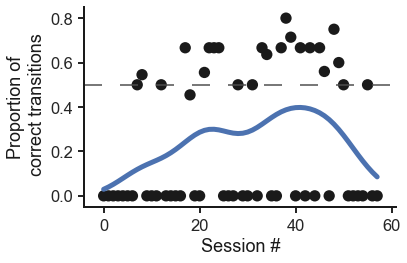

In [498]:
from scipy.ndimage import gaussian_filter1d
sess_perf = [np.nanmean(i) for i in all_fc if not np.isnan(np.nanmean(i))][1:]
plt.plot(gaussian_filter1d(sess_perf,5,mode='nearest'),linewidth=5)
plt.scatter(range(len(sess_perf)),sess_perf,color='k',s=128,edgecolors='none')
plt.axhline(y=0.5,dashes=(12,12),color='.3')
plt.xlabel("Session #")
plt.ylabel("Proportion of\n correct transitions")
#plt.xlim(-.5)
plt.ylim
seaborn.despine()
plt.tight_layout()
#plt.savefig("/Users/yves/Desktop/tpf/navi_learning.svg")
#plt.savefig("/Users/yves/Desktop/tpf/navi_learning.png",dpi=300)


In [499]:
all_ctr

125

In [500]:
all_perf

87

In [501]:
all_perf/all_ctr

0.696

In [502]:
stt.binom_test(all_perf,all_ctr,p=0.5)

1.386303612040122e-05

In [503]:
from statsmodels.stats import proportion

In [504]:
mu = all_perf/all_ctr

In [505]:
#mu - ci

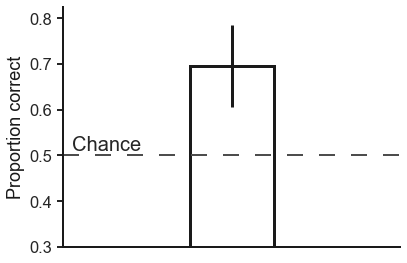

In [464]:
ci = np.array(proportion.proportion_confint(71,107))
#plt.title("Policy update inference")
plt.errorbar([0],[all_perf/all_ctr],yerr=.09,color='k',linewidth=3)
plt.bar([0],[all_perf/all_ctr],facecolor='w',edgecolor='k',linewidth=3,width=.25)
plt.axhline(y=0.5,dashes=(8,8),color='.3',linewidth=2)
plt.annotate("Chance",(.025,.40),xycoords='axes fraction',fontsize=20)
plt.xticks([])
plt.ylim(.3)
plt.xlim(-.5,.5)
plt.ylabel("Proportion correct")
seaborn.despine()
plt.tight_layout()
#plt.savefig("/Users/yves/Desktop/tpf/navi_inf.svg")
#plt.savefig("/Users/yves/Desktop/tpf/navi_inf.png",dpi=300)


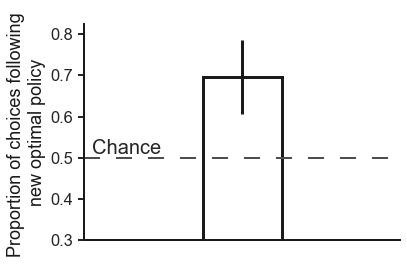

In [451]:
ci = np.array(proportion.proportion_confint(71,107))
#plt.title("Policy update inference")
plt.errorbar([0],[all_perf/all_ctr],yerr=.09,color='k',linewidth=3)
plt.bar([0],[all_perf/all_ctr],facecolor='w',edgecolor='k',linewidth=3,width=.25)
plt.axhline(y=0.5,dashes=(8,8),color='.3',linewidth=2)
plt.annotate("Chance",(.025,.40),xycoords='axes fraction',fontsize=20)
plt.xticks([])
plt.ylim(.3)
plt.xlim(-.5,.5)
plt.ylabel("Proportion of choices following \nnew optimal policy")
seaborn.despine()
plt.tight_layout()
plt.savefig("/Users/yves/Desktop/tpf/navi_inf.svg")
plt.savefig("/Users/yves/Desktop/tpf/navi_inf.png",dpi=300)
